In [122]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

В качестве тестовых данных мы будем использовать отзывы к фильмам, которые уже размечены как положительные и негативные. 

Загрузим датасеты - отдельно для обучения и теста. Загрузка может занять некоторое время

In [106]:
%%time
reviews_train = load_files("aclImdb/train/")
text_train, y_train = reviews_train.data, reviews_train.target

CPU times: user 2.09 s, sys: 5.65 s, total: 7.74 s
Wall time: 14.3 s


In [107]:
print("Число отзывов для обучения: %d" % len(text_train))
print(np.bincount(y_train))

Число отзывов для обучения: 25000
[12500 12500]


In [108]:
%%time
reviews_test = load_files("aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target

CPU times: user 2.19 s, sys: 5.72 s, total: 7.92 s
Wall time: 14 s


In [109]:
print("Число отзывов для валидации: %d" % len(text_test))
print(np.bincount(y_test))

Число отзывов для валидации: 25000
[12500 12500]


### Примеры текстов

Пример негативного отзыва

In [112]:
print(text_train[10], y_train[10])

b"Probably the worst Dolph film ever. There's nothing you'd want or expect here. Don't waste your time. Dolph plays a miserable cop with no interests in life. His brother gets killed and Dolph tries to figure things out. The character is just plain stupid and stumbles around aimlessly. Pointless." 0


Пример положительного отзыва

In [114]:
print(text_train[5], y_train[5])

b"The Movie was sub-par, but this Television Pilot delivers a great springboard into what has become a Sci-Fi fans Ideal program. The Actors deliver and the special effects (for a television series) are spectacular. Having an intelligent interesting script doesn't hurt either.<br /><br />Stargate SG1 is currently one of my favorite programs." 1


### Мешок слов

<img src=https://cdn-images-1.medium.com/max/1200/1*eUedufAl7_sI_QWSEIstZg.png>

Преобразуем слова в признаки - для этого нужно составить словарь слов и каждому слову сопоставить число

In [142]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

Преобразуем выборки, может быть небыстро

In [119]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

### Что такое разреженная матрица?

<img src=http://btechsmartclass.com/data_structures/ds_images/Triplet_Representation_of_Sparse_Matrix.png>

Сравним текст и его представление для обучения

In [117]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [120]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562], dtype=int32))

In [121]:
X_test = cv.transform(text_test)

### Обучим классификатор

In [134]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=27)
logit.fit(X_train, y_train)

CPU times: user 27.9 s, sys: 633 ms, total: 28.6 s
Wall time: 43.7 s


In [123]:
%%time
forest = RandomForestClassifier(n_jobs=-1, random_state=7)
forest.fit(X_train, y_train)

CPU times: user 14.8 s, sys: 230 ms, total: 15 s
Wall time: 8.5 s


In [129]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(forest.estimators_[0], 
                feature_names=cv.get_feature_names(),
                filled=True,
                rounded=True)

/usr/local/lib/python3.5/site-packages/sklearn/tree/export.py:386: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


### Найдем точность алгоритма

In [135]:
round(logit.score(X_test, y_test), 3)

0.867

### Какие слова влияют на классификацию?

In [144]:
def visualize_coefficients(classifier, feature_names, n_top_features=10):
    
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "green" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right");

    
def plot_grid_scores(grid, param_name):
    
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();

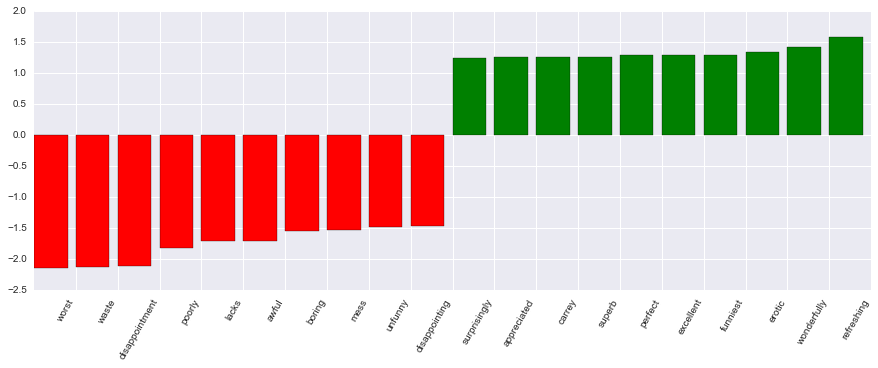

In [139]:
visualize_coefficients(logit, cv.get_feature_names())

Задание

Добавьте биграмы к классификации - для этого в экземпляре класса `CountVectorizer` нужно указать `n_gram_range`. Затем переобучите логистическую регрессию и посмотрите, изменилась ли точность предсказания. Какие слова сейчас определяют принадлежность к классам?

In [ ]:
* в репозитории есть `news_dataset` - новости на русском с разметкой на положительные и негативные. Обучите логистическую регрессию